In [1]:
from scapy.all import *
import pandas as pd 
import numpy as np 
import binascii
import seaborn as sns
sns.set(color_codes = True)
%matplotlib inline

## Capturando 100 paquetes

In [2]:
amount_of_packets = 100
pcap = sniff(count = amount_of_packets)
print("Tipo del pcap: ",type(pcap))
print("Largo del pcap: ", len(pcap))
print(pcap)

Tipo del pcap:  <class 'scapy.plist.PacketList'>
Largo del pcap:  100
<Sniffed: TCP:29 UDP:68 ICMP:0 Other:3>


## Cargando el archivo

In [3]:
path = "analisis_paquetes.pcap"

In [4]:
file = rdpcap(path)

In [5]:
print(file)

<analisis_paquetes.pcap: TCP:0 UDP:62 ICMP:0 Other:0>


In [6]:
pcap = pcap + file
print(pcap)

<Sniffed+analisis_paquetes.pcap: TCP:29 UDP:130 ICMP:0 Other:3>


## Convirtiendo a DataFrame

Se utiliza el código de ejemplo proporcionado en clase

In [10]:
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

dataframe_fields = ip_fields + ["time"] + tcp_fields + ['payload','payload_raw','payload_hex']

df = pd.DataFrame(columns = dataframe_fields)

for packet in pcap[IP]:
    field_values = []
    for field in ip_fields:
        if field == "options":
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    field_values.append(packet.time)
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field =="options":
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

df = df.reset_index()
df = df.drop(columns="index")
df.head()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,98,30008,,0,255,17,41884,...,None,None,None,None,6744,None,None,70,b'\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00...,b'0000000000010000000000010c5f736c6565702d7072...
1,4,5,0,153,21115,DF,0,1,17,29989,...,None,None,None,None,27409,None,None,125,b'M-SEARCH * HTTP/1.1\r\nHOST: 239.255.255.250...,b'4d2d534541524348202a20485454502f312e310d0a48...
2,4,5,0,153,21146,DF,0,1,17,29958,...,None,None,None,None,27409,None,None,125,b'M-SEARCH * HTTP/1.1\r\nHOST: 239.255.255.250...,b'4d2d534541524348202a20485454502f312e310d0a48...
3,4,5,0,367,46531,,0,4,17,19991,...,None,None,None,None,54134,None,None,339,b'NOTIFY * HTTP/1.1\r\nHost: 239.255.255.250:1...,b'4e4f54494659202a20485454502f312e310d0a486f73...
4,4,5,0,312,46532,,0,4,17,20045,...,None,None,None,None,29585,None,None,284,b'NOTIFY * HTTP/1.1\r\nHost: 239.255.255.250:1...,b'4e4f54494659202a20485454502f312e310d0a486f73...


## Columnas Src Address, Dst Address, Src Port y Dst Port

In [11]:
df[['src','dst','sport','dport']]

,src,dst,sport,dport
0,192.168.1.18,224.0.0.251,5353,5353
1,192.168.1.17,239.255.255.250,44329,1900
2,192.168.1.17,239.255.255.250,44329,1900
3,192.168.1.1,239.255.255.250,1900,1900
4,192.168.1.1,239.255.255.250,1900,1900
...,...,...,...,...
103,84.54.22.33,10.1.10.53,53,53
104,10.1.10.53,84.54.22.33,53,53
105,84.54.22.33,10.1.10.53,53,53
106,10.1.10.53,84.54.22.33,53,53


## Estadistica

In [23]:
top = df['src'].describe()['top']
print(top)

10.1.10.53


In [18]:
df['dst'].describe()['top']

'10.1.10.53'

In [24]:
df['dst'][df['src'] == top].value_counts()

84.54.22.33    29
75.75.75.75     2
Name: dst, dtype: int64

La IP se comunica al IP 85.54.22.33

In [25]:
df['dport'][df['src'] == top].value_counts()

53    31
Name: dport, dtype: int64

La ip se comunica al puerto 53

In [26]:
df['sport'][df['src'] == top].value_counts()

53       29
15812     1
23903     1
Name: sport, dtype: int64

En su mayoria el Ip se comunica al puerto origen 53

Este puerto se utiliza para el DNS, servicio que se utitiliza para la resolución de nombres de dominio

## Gráficas

Suma de payloads enviados por IP

<AxesSubplot:xlabel='count', ylabel='src'>

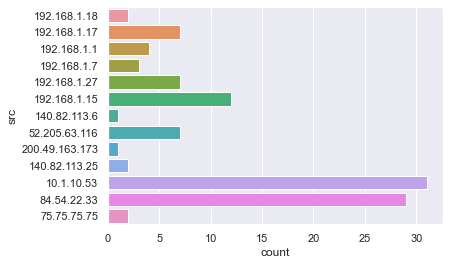

In [67]:
sns.countplot(
    data = df,
    y = 'src',
)

Suma de payloads recividos por IP

<AxesSubplot:xlabel='count', ylabel='dst'>

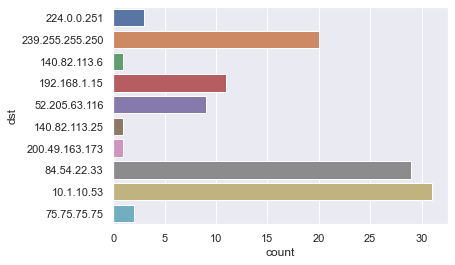

In [76]:
sns.countplot(
    data = df,
    y = 'dst',
)

Suma de payloads enviados por puerto

<AxesSubplot:xlabel='count', ylabel='sport'>

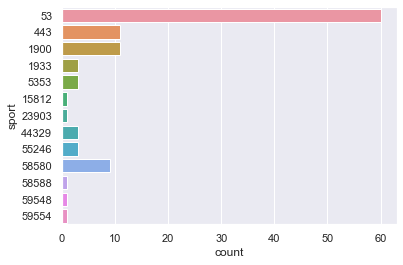

In [69]:
sns.countplot(
    data = df,
    y = 'sport',
)

Suma de payloads recividos por puerto

<AxesSubplot:xlabel='count', ylabel='dport'>

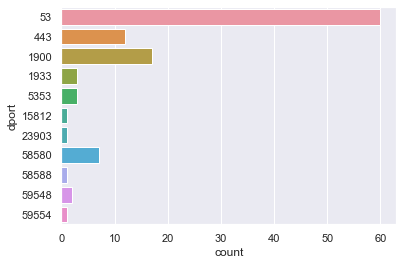

In [70]:
sns.countplot(
    data = df,
    y = 'dport',
)

## Investigacion payload

In [79]:
df_top = df[df['src'] == top]
df_top

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
46,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
48,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
50,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
52,4,5,0,998,1,,0,64,17,21185,...,None,None,None,None,65315,None,None,970,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
54,4,5,0,1003,1,,0,64,17,21180,...,None,None,None,None,38088,None,None,975,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
56,4,5,0,1045,1,,0,64,17,21138,...,None,None,None,None,5707,None,None,1017,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
58,4,5,0,1008,1,,0,64,17,21175,...,None,None,None,None,31270,None,None,980,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
60,4,5,0,979,1,,0,64,17,21204,...,None,None,None,None,11600,None,None,951,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
62,4,5,0,959,1,,0,64,17,21224,...,None,None,None,None,7922,None,None,931,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
64,4,5,0,992,1,,0,64,17,21191,...,None,None,None,None,22145,None,None,964,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


In [125]:
top_talks_to = df_top['dst'].unique()

In [126]:
print(top_talks_to)

['84.54.22.33' '75.75.75.75']


In [127]:
df_top['dst'].value_counts()

84.54.22.33    29
75.75.75.75     2
Name: dst, dtype: int64

In [128]:
suspicious = top_talks_to[0]

In [123]:
print(suspicious)

84.54.22.33


In [131]:
df_sus = df_top[df_top["dst"]== suspicious]
df_sus

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
46,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
48,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
50,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
52,4,5,0,998,1,,0,64,17,21185,...,None,None,None,None,65315,None,None,970,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
54,4,5,0,1003,1,,0,64,17,21180,...,None,None,None,None,38088,None,None,975,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
56,4,5,0,1045,1,,0,64,17,21138,...,None,None,None,None,5707,None,None,1017,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
58,4,5,0,1008,1,,0,64,17,21175,...,None,None,None,None,31270,None,None,980,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
60,4,5,0,979,1,,0,64,17,21204,...,None,None,None,None,11600,None,None,951,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
62,4,5,0,959,1,,0,64,17,21224,...,None,None,None,None,7922,None,None,931,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
64,4,5,0,992,1,,0,64,17,21191,...,None,None,None,None,22145,None,None,964,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


In [158]:
array = df_sus['payload_raw'].to_numpy()

In [159]:
for i in array:
    print(i,"\n\n")

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbdPNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01b\x00\x00\x00\xef\xbf\xbd\x08\x06\x00\x00\x00(\xef\xbf\xbdTR\x00\x00:\xef\xbf\xbdIDATx\xef\xbf\xbd\xef\xbf\xbd\t|T\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd;K\x12\x08;\x08\xef\xbf\xbd\nE\xef\xbf\xbd\xef\xbf\xbd$\x19\xef\xbf\xbd\xef\xbf\xbdZi\xdf\xaa-\xef\xbf\xbd;N2\xef\xbf\xbd\xef\xbf\xbdV\xef\xbf\xbdV\xef\xbf\xbda\xef\xbf\xbdZ\x11!\xef\xbf\xbd\xef\xbf\xbd\x01\xdc\xbbik[\xef\xbf\xbd.ok\xef\xbf\xbde\xef\xbf\xbd\x01\\\xef\xbf\xbd\xef\xbf\xbd]\xef\xbf\xbd-\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdd\xef\xbf\xbd\x08\xef\xbf\xbd\x08\xef\xbf\xbd\xef\xbf\xbdg\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd<\xef\xbf\xbd\xef\xbf\xbdL\x12\xef\xbf\xbd$3wf\xef\xbf\xbd\xef\xbf\xbd\x02<_\r\xef\xbf\xbdY\xef\xbf\xbdr\xef\xbf\xbd\xef\xbf\xbdy\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x1c\r\x18\xef\xbf\xbd8c\xef\xbf\xbdew\r\x1e\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbd\xef\xbf\xbd^n\xef\xbf\xbd\'\'\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd$\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdR\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x17\xef\xbf\xbd>Epou\xef\xbf\xbd\xef\xbf\xbd$\xef\xbf\xbd\xef\xbf\xbdM\xef\xbf\xbd\xef\xbf\xbd\x1c\xef\xbf\xbd\xef\xbf\xbd\x0e\xef\xbf\xbdtB\r\xef\xbf\xbd\xd4\xbag\xef\xbf\xbdm\xef\xbf\xbd\xef\xbf\xbd>8w\xe8\x84\xaa\xef\xbf\xbd\xef\xbf\xbd5\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd<\xef\xbf\xbd>\xef\xbf\xbd\x19\xef\xbf\xbd\xef\xbf\xbdl\x0e<p\xef\xbf\xbd\xef\xbf\xbd\xc7\x98\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdw8\xef\xbf\xbd\xef\xbf\xbd@\xd4\xae\xef\xbf\xbd`Y\xef\xbf\xbd\xef\xbf\xbd\x15\xef\xbf\xbdoR\xef\xbf\xbdH\xef\xbf\xbd\xef\xbf\xbdhD\xef\xbf\xbd(\xef\xbf\xbd;\xef\xbf\xbd8*~o\x14`Y\xef\xbf\xbdm\xef\xbf\xbd\x15\xef\xbf\xbd?\xef\xbf\xbd\x16\xcb\xa1\t\xef\xbf\xbd\x04DJ\xef\xbf\xbd1PD\xef\xbf\xbd\x143O\xef\xbf\xbd\x16UU\x18\xef\xbf\xbd

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xcb\xb4\xef\xbf\xbd\x16\xef\xbf\xbd\xef\xbf\xbdrj\xef\xbf\xbdGBWO\xef\xbf\xbd\xef\xbf\xbd\x18\xdd\xa2i\xef\xbf\xbd\xef\xbf\xbd0\xef\xbf\xbd\x18\x01\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x13e"3\x1cY\r\rP\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd^nQ\x0c\x0b1\xef\xbf\xbd\x16\x13/\\8$\'\xcb\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd!\xef\xbf\xbd<~\xef\xbf\xbdK"\xef\xbf\xbdd\x00\xef\xbf\xbd\xef\xbf\xbd\x19\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdb\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\t\x1b\xef\xbf\xbd6\xef\xbf\xbdp\xef\xbf\xbdb\x12\xef\xbf\xbd\xef\xbf\xbd\t\xef\xbf\xbd\x0bC\xef\xbf\xbd\xef\xbf\xbd\x17EE\xef\xbf\xbd\xc9\x80Q\xef\xbf\xbd \xef\xbf\xbd\rOrA0,\xef\xbf\xbdLZ(\x12[\xef\xbf\xbd\x142\xef\xbf\xbdv.\x02\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdI\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd+"z\xef\xbf\xbdK"\x03\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01VQ\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdG-U\xef\xbf\xbd|\xef\xbf\xbdp\xef\xbf\xbd\xef\xbf\xbd`^\x0b\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd)\xef\xbf\xbd\x1aA\xef\xbf\xbd":\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x01\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdI"\xef\xbf\xbd\xef\xbf\xbd/\x06\x01C\x05\xef\xbf\xbdp\x12p\xef\xbf\xbd\x00\xef\xbf\xbd\x05\x00\xef\xbf\xbd\xd0\x81N\xef\xbf\xbd\x080QgKx\xd7\x81\xef\xbf\xbdp\xef\xbf\xbd\x07\xef\xbf\xbd\xef\xbf\xbd{\xef\xbf\xbdk\xef\xbf\xbda!fN^\xcb\xb8\xef\xbf\xbd\xef\xbf\xbdG3\xef\xbf\xbd%;\x1c\xef\xbf\xbd|"6\tP\xef\xbf\xbd`\xef\xbf\xbd-\xef\xbf\xbd\xef\xbf\xbd-\x11f\x03\xef\xbf\xbdM2\xef\xbf\xbd\x11l\xef\xbf\xbd6\xd6\xa5!;\xef\xbf\xbd\xef\xbf\xbdZ\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd{\xef\xbf\xbd\xef\xbf\xbdv\xef\xbf\xbdfG@\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd/\xef\xbf\xbdP\x06"-\xef\xbf\xbd\x1a\x

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbd\xef\xbf\xbd\x1e\x00\xce\x9ar\xef\xbf\xbd>\xce\x99m\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\r\x00\xef\xbf\xbdn\xef\xbf\xbd\x0c\xef\xbf\xbd!E\xef\xbf\xbd\xef\xbf\xbd$\xef\xbf\xbd[&\xef\xbf\xbd%3\x0c\x0b1\xef\xbf\xbd\tl\xef\xbf\xbdd\xef\xbf\xbd\xef\xbf\xbd\x1e\xef\xbf\xbdw\xef\xbf\xbd\xef\xbf\xbd\x19c;\x00\xef\xbf\xbdl\xef\xbf\xbda\xef\xbf\xbd\xef\xbf\xbd\n\xef\xbf\xbd \xef\xbf\xbdY\x1d\x014s\xef\xbf\xbd\xef\xbf\xbd8ph\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdNV\xef\xbf\xbdd.\xef\xbf\xbd\x13r\xef\xbf\xbd\x1d\xef\xbf\xbd\xef\xbf\xbd7\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdLX\xef\xbf\xbd\xef\xbf\xbd\x01\xef\xbf\xbd\x02x%\xef\xbf\xbdw)\xef\xbf\xbd\xef\xbf\xbdIs\xef\xbf\xbd\\.\xef\xbf\xbd\x13\xef\xbf\xbd\xef\xbf\xbd+\x16MF\xef\xbf\xbd\x0e\xde\xab\xef\xbf\xbd\xef\xbf\xbdK\\2,\xef\xbf\xbd\xef\xbf\xbd\x00\xef\xbf\xbd\xef\xbf\xbd{\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd*\x0b\x06\x0f\xef\xbf\xbd\x7fq\xc9\

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd<>}\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd%\xef\xbf\xbd\xef\xbf\xbdR\xef\xbf\xbdA\x08\xef\xbf\xbd\xef\xbf\xbdt\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\\\x07@c\xef\xbf\xbd-\xef\xbf\xbdG\xef\xbf\xbd9\xef\xbf\xbdu9\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdE%wq\xef\xbf\xbd\xef\xbf\xbd\x0f\x0e\xef\xbf\xbd\xef\xbf\xbdo\xef\xbf\xbd\xef\xbf\xbdc\xef\xbf\xbd.\xef\xbf\xbd8\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdg\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\n!\xef\xbf\xbd\xef\xbf\xbd.\xef\xbf\xbd|\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x04\xef\xbf\xbdp\xef\xbf\xbd&:\xef\xbf\xbdb=\x16\x0f\x14c\xef\xbf\xbd\xef\xbf\xbdd\xef\xbf\xbd<\xef\xbf\xbd\xef\xbf\xbdW\xef\xbf\xbd\x08\x1b\xe5\x96\x8eM\x1e\xef\xbf\xbd\xef\xbf\xbdR\xde\x97\xef\xbf\xbd\xef\xbf\xbd\\2\xe9\xa0\x8bB\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd^"+#m>r\x0cR\x16\x08)\x1f(,\xef\xbf\xbd\xef\xbf\xbd\x1d9\x07\xef\xbf\xbds\x1f\xef\xb

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdp\xef\xbf\xbdQ!e\xef\xbf\xbd\x1e\x12\xef\xbf\xbd%\\\xd8\xaf^Z\xdb\x95 \xef\xbf\xbd=\x02"L{\xef\xbf\xbd\t\x11\xef\xbf\xbd\x12\x11\x17ti\xef\xbf\xbd\x0e\xef\xbf\xbdGB|\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd,7\xef\xbf\xbd\x07\xef\xbf\xbdp6K\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd[\xef\xbf\xbd\xea\x8e\xb8\x0e\xef\xbf\xbd\x1a\xef\xbf\xbd\xef\xbf\xbd\x02\x1as\xd1\x9d9\xef\xbf\xbdr\xef\xbf\xbd@6\xef\xbf\xbd\xef\xbf\xbdLT\xef\xbf\xbdVc\xef\xbf\xbds\xef\xbf\xbd\xef\xbf\xbd\x1f(\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x0fW\x16\xef\xbf\xbd`\xef\xbf\xbd@\xef\xbf\xbdMl\xef\xbf\xbdi\xef\xbf\xbd\xef\xbf\xbd,Z\xef\xbf\xbd\xd9\xba\xef\xbf\xbd\xef\xbf\xbdo\xef\xbf\xbd\xef\xbf\xbd\\\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdCE\x16dG\xef\xbf\xbd\x01A\xef\xbf\xbd\xd4\x81pcm\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbda\xef\xbf\xbd\xef\xbf\xbd\x05.5(\xef\xbf\xbd\xef\xbf\xbd4e\xef\xbf\xbd\x

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01*\x0b\xef\xbf\xbd\xcb\xaa\xef\xbf\xbdf\xef\xbf\xbdu\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd>\xef\xbf\xbd\x07g\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd6\x1dP`=/@\\\xef\xbf\xbd\xef\xbf\xbds\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x18\xef\xbf\xbd"Xi\x1f\xd7\x8aV\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdS\xef\xbf\xbd?\x03\x00\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x12\xef\xbf\xbd\x0b\xef\xbf\xbd;\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd"l\x7f\xef\xbf\xbd\xef\xbf\xbd,\xef\xbf\xbd4!~\x07g\xef\xbf\xbd;\x10\xef\xbf\xbd\xef\xbf\xbdR=\xef\xbf\xbd\xef\xbf\xbdWV#\xef\xbf\xbd\xef\xbf\xbdF\xef\xbf\xbdQ\xef\xbf\xbdF\x17G\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xd5\x85>}g\xef\xbf\xbd\x06?\xef\xbf\xbd\t\xef\xbf\xbd\xef\xbf\xbd\x05pN\xe

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\x1d9\xef\xbf\xbd\x15\xc6\xb8\xef\xbf\xbd\nc\xef\xbf\xbd\xef\xbf\xbd{\x1b\xef\xbf\xbd(\xef\xbf\xbd\xef\xbf\xbd6\x17\t\x05\xef\xbf\xbd\xef\xbf\xbdo\xef\xbf\xbd"\x1d\xef\xbf\xbdv\xef\xbf\xbdKD\xef\xbf\xbd\xef\xbf\xbdP\xcb\xa4\xef\xbf\xbd\xef\xbf\xbd\x18\x1d\\Q6E\x11\xef\xbf\xbd"\xef\xbf\xbdWCk\xef\xbf\xbd-\x18\x17\xef\xbf\xbd\x1b\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x04 \xef\xbf\xbd]]\tTq\xef\xbf\xbdx\xd6\xbcE\xef\xbf\xbdG\x01\xef\xbf\xbd\xef\xbf\xbd]\xef\xbf\xbdK\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x02\xef\xbf\xbd\x04\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\n\xef\xbf\xbd\xcc\xa0\xef\xbf\xbdl\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd[\xef\xbf\xbd\xef\xbf\xbd`q\x17\n\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdD\xef\xbf\xbdx\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdr\xef\xbf\xbd\xef\xbf\xbdy\x0bSJ\xef\xbf\xbdSPTr\x0e\xef\xbf\xbd8\xef\xbf\xbdk}\xef\xbf\xbd\xef\xbf\xbd\r\xef\xbf\xbd\x0b2\xef\xbf\xbd^!e\xef\

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbd\xef\xbf\xbdX\xef\xbf\xbd\xef\xbf\xbd\t\xef\xbf\xbd\xf3\xbc\x89\xb7\xef\xbf\xbd9ux\xef\xbf\xbd2\xef\xbf\xbdL\x1b\xef\xbf\xbd\xef\xbf\xbd\x16\xd8\x8e\xef\xbf\xbd\xef\xbf\xbd\\\x01H4\xef\xbf\xbd#\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x08\xef\xbf\xbd\x7f\xef\xbf\xbd~\xef\xbf\xbd\xdd\x9an\xef\xbf\xbd\xef\xbf\xbdV^\xd4\xb5n[ p\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd]r\xef\xbf\xbdH\xef\xbf\xbdiv\xe1\x99\x9a\n\xef\xbf\xbd\x7f\x12\x1doVQ\xef\xbf\xbd\x11\xef\xbf\xbd\xef\xbf\xbd6&TB\xef\xbf\xbd\xef\xbf\xbd.\xef\xbf\xbdl#\x014\xef\xbf\xbd\r\xe6\xb3\xbc\xd3\xae\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdA\xef\xbf\xbd\xef\xbf\xbd7\xef\xbf\xbdX\xef\xbf\xbd\xef\xbf\xbdw\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdzJ\xef\xbf\xbd\xef\xbf\xbd\x023\xef\xbf\xbd\xef\xbf\xbdbrO0rM\xef\xbf\xbdD}\xef\xbf\xbd\xef\xbf\xbdI*~\xde\x8b\xef\xbf\xbd\xef\xbf\xbd\x02\xef\xbf\xbd_\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xda\xb5c-;I\xef\

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\t\xef\xbf\xbd\xef\xbf\xbd"\xef\xbf\xbdR\xef\xbf\xbdk\xef\xbf\xbdJt\x06QJ\xef\xbf\xbd2\xef\xbf\xbd7\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd$h\xef\xbf\xbd\xef\xbf\xbd\x136&\xef\xbf\xbd\xef\xbf\xbdrsGD\xef\xbf\xbd)IX\xef\xbf\xbd\xef\xbf\xbd\xcb\x8a\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x04\x14n:\xef\xbf\xbd0\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdn\xef\xbf\xbd\xef\xbf\xbd\t\xef\xbf\xbd\xef\xbf\xbdK\xef\xbf\xbd>+$vq\r\xef\xbf\xbd]\xce\x85\xef\xbf\xbdY\xef\xbf\xbde\xef\xbf\xbd>\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd^If(\x14x\xef\xbf\xbd\xef\xbf\xbd\x1ew*\x15\xef\xbf\xbd\xef\xbf\xbdB}\xef\xbf\xbd\xef\xbf\xbd\x03\xef\xbf\xbd\xef\xbf\xbdv+(K\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd}\xda\x98MD\xef\xbf\xbdHGO\xef\xbf\xbd\xef\xbf\xbd\x1deE\xef\xbf\xbd\xef\xbf\xbd\x14\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xdc\xa5\xef\xbf\xbdz\x7f\x05k4\xef\xbf\xbd\

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\x7f0\xef\xbf\xbd6r\xef\xbf\xbd\x16\xef\xbf\xbd\x1eaB\xef\xbf\xbd\xef\xbf\xbd0LOb1\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdE\xef\xbf\xbd\xef\xbf\xbdv\xef\xbf\xbd\xef\xbf\xbd\x1cN\xef\xbf\xbdzF\x1d6\x05\xef\xbf\xbd\xef\xbf\xbd\x16\xef\xbf\xbd\xef\xbf\xbd+\xef\xbf\xbd\x07\x11.,R\xef\xbf\xbdE\xef\xbf\xbd!\xc9\x92\xef\xbf\xbd\x13B\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x1cjJd\x1dR\xef\xbf\xbd\xef\xbf\xbd7\xef\xbf\xbd\x1a\xef\xbf\xbd\'l:4X\xef\xbf\xbd\xef\xbf\xbdq\x0e\x189\'\xef\xbf\xbd\xef\xbf\xbdO@\xef\xbf\xbd\xef\xbf\xbd\xd8\x87%\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdjH\xef\xbf\xbd~\xef\xbf\xbd\xef\xbf\xbd)\n\xef\xbf\xbd\xef\xbf\xbdO\xef\xbf\xbdv/\xef\xbf\xbd\xef\xbf\xbd<\xef\xbf\xbdIf\x00\xef\xbf\xbdem\xef\xbf\xbd\xc4\x86\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x11\xef\xbf\xbd;q\xef\xbf\xbd\xef\xbf\xbd\xef\xbf

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01P$\x08\x05+\xef\xbf\xbd\x0b2\x13\xef\xbf\xbdM<?\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdt\xef\xbf\xbdDq\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdsE\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x0e\xef\xbf\xbd\x05E\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x10Et\xcf\xb9x\xef\xbf\xbdp\x06\x0fwE\xea\xb3\xb4\xef\xbf\xbdqP\\\xef\xbf\xbdXHq~\xef\xbf\xbd\xef\xbf\xbd]\n\xd4\xaa\x04\xef\xbf\xbd\xef\xbf\xbd*\xef\xbf\xbd\xef\xbf\xbd*\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xe8\xa6\xb134\xef\xbf\xbd\xef\xbf\xbd1\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdrie\\+\x7f\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd!\xef\xbf\xbd\x06c\x14\xef\xbf\xbd`6\xef\xbf\xbd=\xef\xbf\xbd\xef\xbf\xbd\x11<\xef\xbf\xbd\x08W\xef\xbf\xbd\x14\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdH\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdx)U\x037\xef\xbf\xbd*\xef\xbf\xbd\xef\xbf\xbdq\xef\xbf\xbd\xef\xbf\xbdK)\xef\xbf\xbdN\xe

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbdK\xef\xbf\xbde\xef\xbf\xbd4\xef\xbf\xbdP$M\x11q\xef\xbf\xbd\xef\xbf\xbde\xef\xbf\xbd\xef\xbf\xbd\x08\xef\xbf\xbdV\xef\xbf\xbdq\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\n\xef\xbf\xbd7\xef\xbf\xbd|/\xef\xbf\xbd7\xef\xbf\xbd\xef\xbf\xbdR\x0fe\xef\xbf\xbd\x1a\xc2\xa6\xef\xbf\xbdH\xef\xbf\xbd\xef\xbf\xbd\xca\xaf\xef\xbf\xbd\x15\xef\xbf\xbd\x1b#\x14Q\xef\xbf\xbdw\xef\xbf\xbdP\x00\xef\xbf\xbd\xef\xbf\xbdIu\xc8\x85[\x1f06%\xef\xbf\xbd#+\x03\xef\xbf\xbdlY\xef\xbf\xbd\xef\xbf\xbd\'\xef\xbf\xbd/\xcb\xa9\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdMu\xef\xbf\xbd\xef\xbf\xbd\x0b\xef\xbf\xbd\x19\xef\xbf\xbd\x0c\x11\xef\xbf\xbd\xef\xbf\xbd\x08\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdPS\xef\xbf\xbdS~BG\xef\xbf\xbdoI%\xef\xbf\xbd\x08\n\r\xc2\xa1\xef\xbf\xbd+3Q~5\x15\xef\xbf\xbd\x1e6\xef\xbf\xbd\xef\xbf\xbdk\xce\x9c\x08\xef\xbf\xbd\xef\xbf\xbdaE\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd(\x7f\x08\x06\x00\xef\xbf\xbdR\xef\xbf\xbd\xe

b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01w\xef\xbf\xbd\x04\x10\xef\xbf\xbd[y\xef\xbf\xbd\xef\xbf\xbd4\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x07\xef\xbf\xbd\xed\x8c\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdQ9c\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x15\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd}\x0c\x17\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x02u\xef\xbf\xbde\x1ac\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbddB\x1c\xef\xbf\xbd\xef\xbf\xbd\r\xef\xbf\xbdR:q\x10\\\x04\x0c\xef\xbf\xbd0,\xef\xbf\xbd\x0c\xef\xbf\xbd0,\xef\xbf\xbd\x0c\xef\xbf\xbd0\x0c\x0b1\xef\xbf\xbd0\x0c\x0b1\xef\xbf\xbd0\x0c\xef\xbf\xbdB\xef\xbf\xbd0\x0c\xef\xbf\xbdB\xef\xbf\xbd0\x0c\xc3\xb0\x103\x0c\xc3\xb0\x103\x0c\xef\xbf\xbd0}\xef\xbf\xbd\xef\xbf\xbdE\xef\xbf\xbd0\xef\xbf\xbd\x19\x08\xda\x8cy\xef\xbf\xbdT\xef\xbf\xbdh\xde\xb16\xef\xbf\xbd>\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdL\x7fU)\xef\xbf\xbd0\x03\x03\xef\xbf\xbdW\xef\xbf\xbd\xef

Examine los primeros bytes del contenido, ¿encuentra algún dato que no haga sentido 
que se envie a través del puerto explicado en el inciso f? 

En el primer payload se puede observar que se esta enviando un archivo con fomrato PNG, esto no tiene sentido ya que DNS se encarga de resolver los IPs de nombres de Dominio, enviar PNG a este puerto probablemente indica algun tipo de exploit que se esta tratando de realizar al sistema